# Imports

In [ ]:
import os
import torch
import random
import math
import h5py
import torchaudio
import logging
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
import seaborn as sns
from cycler import cycler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch.optim import lr_scheduler
from google.colab import drive, runtime
from tqdm import tqdm
from torch.utils.data import BatchSampler, TensorDataset, DataLoader, Dataset, Subset
from torchvision import models, transforms
from torchvision.transforms import v2
!pip install audiomentations
!pip install torch-audiomentations
!pip install torchinfo
!pip install pytorch-metric-learning
!pip install faiss-cpu
import faiss
import audiomentations as C
import torch_audiomentations as G
from pytorch_metric_learning import losses, miners, regularizers, samplers, distances, reducers, trainers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from torchinfo import summary

drive.mount('/content/drive')

Mounted at /content/drive


# Data

Data Augmentation

In [ ]:
class DataAugmentationCPU(nn.Module):
    def __init__(self):
        super(DataAugmentationCPU, self).__init__()
        self.transforms = C.Compose([
            C.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
            C.TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
            C.PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
        ])

    def forward(self, song, sample_rate):
        augmented_song = self.transforms(song, sample_rate=sample_rate)
        return augmented_song

Dataset Mean/Std

In [ ]:
# From: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def dataset_mean_std(data_loader):
  nimages = 0
  mean = 0.
  std = 0.
  for batch, _ in data_loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      # Update total number of images
      nimages += batch.size(0)
      # Compute mean and std here
      mean += batch.float().mean(2).sum(0)
      std += batch.float().std(2).sum(0)

  # Final step
  mean /= nimages
  std /= nimages

  print("Training set mean", mean)
  print("Training set std", std)

  return mean, std

Create Dataset

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, file_path, sample_rate=16000, n_mels=128, mean=6.5226, std=10.4655, transform=None):
        self.file = h5py.File(file_path, 'r')
        self.input_data = self.file['data']
        self.input_labels = self.file['labels']
        self.sr = sample_rate
        self.n_mels = n_mels
        self.mean = mean
        self.std = std
        self.transform = transform
        self.mel_spec_transform = T.MelSpectrogram(sample_rate=self.sr, n_mels=self.n_mels, n_fft=2048, hop_length=512)
        self.log_mel_spec_transform = T.AmplitudeToDB()
        self.image_transforms = transform = v2.Compose([
                                                        v2.Resize((64, 47)),
                                                        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                                                        v2.Normalize((self.mean,), (self.std,))
                                                    ])

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        song = self.input_data[idx]
        genre = self.input_labels[idx]
        if self.transform:
            song = self.transform(song, self.sr)

        mel_spec = self.mel_spec_transform(torch.from_numpy(song))
        log_mel_spec = self.log_mel_spec_transform(mel_spec)
        mel_spec_tensor = log_mel_spec.unsqueeze(0)
        mel_spec_tensor = self.image_transforms(mel_spec_tensor)

        return mel_spec_tensor, genre

batch_size = 960

audio_train_dataset = AudioDataset(file_path='/content/drive/My Drive/Projects/NeuraBeat/Data/torchaudio_train_data.h5', transform=None)
audio_val_dataset = AudioDataset(file_path='/content/drive/My Drive/Projects/NeuraBeat/Data/torchaudio_val_data.h5', transform=None)
audio_test_dataset = AudioDataset(file_path='/content/drive/My Drive/Projects/NeuraBeat/Data/torchaudio_test_data.h5', transform=None)

train_batch_sampler = samplers.MPerClassSampler(labels=audio_train_dataset.input_labels, m=120, batch_size=batch_size)
val_batch_sampler = samplers.MPerClassSampler(labels=audio_val_dataset.input_labels, m=120, batch_size=batch_size)
test_batch_sampler = samplers.MPerClassSampler(labels=audio_test_dataset.input_labels, m=120, batch_size=batch_size)

audio_train_loader = DataLoader(audio_train_dataset, batch_size=batch_size, sampler=train_batch_sampler, pin_memory=True)
audio_val_loader = DataLoader(audio_val_dataset, batch_size=batch_size, sampler=val_batch_sampler, pin_memory=True)
audio_test_loader = DataLoader(audio_test_dataset, batch_size=batch_size, sampler=test_batch_sampler, pin_memory=True)

# Model

Print Layer (debugging)

In [ ]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print("X shape:", x.shape)
        return x


Positional Encoding

In [ ]:
# From: https://github.com/wzlxjtu/PositionalEncoding2D
class PositionalEncoding2d(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2d, self).__init__()
        if d_model % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(d_model))
        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                            -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

Separable Convolution 2D Layer

In [ ]:
# Inspired by: https://github.com/reshalfahsi/separableconv-torch
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

Residual Block

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, num_layers: int):
        super().__init__()
        assert num_layers >= 2, "num_layers must be at least 2"
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        self.inconv = nn.Sequential(
            SeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, bias=False),
            nn.SELU()
        )

        layers = []
        for _ in range(num_layers - 2):
            layers.append(SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, bias=False))
            layers.append(nn.SELU())
        self.convlayers = nn.Sequential(*layers)

        self.out_conv = SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, bias=False)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
        self.sact = nn.SELU()

    def forward(self, x):
        out = self.inconv(x)
        out = self.convlayers(out)
        out = self.out_conv(out)

        shortcut = self.shortcut(x)
        out = out + shortcut
        out = self.sact(out)

        return out

Embedding Model

In [ ]:
class EmbeddingModel(nn.Module):
    def __init__(self):
      super(EmbeddingModel, self).__init__()
      self.input_layer = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, bias=False),
          nn.SELU(),
      )

      self.conv_layers = nn.Sequential(
          ResidualBlock(in_channels=8, out_channels=8, kernel_size=3, stride=2, num_layers=2),
          ResidualBlock(in_channels=8, out_channels=16, kernel_size=3, stride=2, num_layers=2),
          ResidualBlock(in_channels=16, out_channels=32, kernel_size=3, stride=2, num_layers=2),
          ResidualBlock(in_channels=32, out_channels=64, kernel_size=3, stride=2, num_layers=2),
      )

      self.dense_layers = nn.Sequential(
          nn.Linear(in_features=64, out_features=256),
          nn.ReLU(),
          nn.Linear(in_features=256, out_features=128),
          nn.ReLU(),
          nn.Linear(in_features=128, out_features=128)
      )

    def forward(self, x):
      x = self.input_layer(x)
      x = self.conv_layers(x)
      x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
      x = self.dense_layers(x)
      return x

    def get_embedding(self, x):
      return self.forward(x)

# Utils

Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def reset_loss(self):
        self.min_validation_loss = float('inf')

Autoclip

In [ ]:
# From: https://github.com/pseeth/autoclip/blob/master/autoclip.py
class AutoClip:
    def __init__(self, percentile):
        self.grad_history = []
        self.percentile = percentile

    def compute_grad_norm(self, model):
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        return total_norm

    def __call__(self, model):
        grad_norm = self.compute_grad_norm(model)
        self.grad_history.append(grad_norm)
        clip_value = np.percentile(self.grad_history, self.percentile)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

Model Checkpoint

In [ ]:
def save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses, train_mined_triplets, val_mined_triplets):
  checkpoint = {
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
          'train_mined_triplets': train_mined_triplets,
          'val_mined_triplets': val_mined_triplets
      }
  torch.save(checkpoint, f'/content/drive/My Drive/Projects/NeuraBeat/Checkpoints/model_checkpoint_{epoch}.pt')
  torch.save(model.state_dict(), f'/content/drive/My Drive/Projects/NeuraBeat/Models/embedding_model_{epoch}.pt')

def load_checkpoint(filepath, model, optimizer, scheduler):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_mined_triplets = checkpoint['train_mined_triplets']
    val_mined_triplets = checkpoint['val_mined_triplets']
    return model, optimizer, scheduler, start_epoch, train_losses, val_losses, train_mined_triplets, val_mined_triplets

# Training

Train Loop

In [ ]:
def train_loop(train_loader, model, miner, criterion, optimizer, device, epoch):
    size = len(train_loader.dataset)
    model.train()
    avg_train_loss = 0.0
    avg_mined_triplets = 0.0
    num_batches = len(train_loader)

    for batch, (inputs, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        triplets = miner(outputs, targets)

        loss = criterion(outputs, targets, triplets)
        avg_train_loss += loss.item()
        avg_mined_triplets += miner.num_triplets
        loss.backward()

        autoclipper(model)
        optimizer.step()

        if (batch + 1) % 10 == 0:
            current_loss = avg_train_loss / (batch + 1)
            current_mined_triplets = avg_mined_triplets / (batch + 1)
            print(f"Training loss: {current_loss:>7f} - Train mined triplets: {current_mined_triplets:>7f}")

    avg_train_loss = avg_train_loss / num_batches
    avg_mined_triplets = avg_mined_triplets / num_batches
    return avg_train_loss, avg_mined_triplets

Val Loop

In [ ]:
def val_loop(val_loader, model, miner, criterion, device, epoch):
    model.eval()
    avg_val_loss = 0.0
    avg_mined_triplets = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            triplets = miner(outputs, targets)

            loss = criterion(outputs, targets, triplets)
            avg_val_loss += loss.item()
            avg_mined_triplets += miner.num_triplets


    avg_val_loss = avg_val_loss / num_batches
    avg_mined_triplets = avg_mined_triplets / num_batches
    return avg_val_loss, avg_mined_triplets

Training

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
embedding_model = EmbeddingModel().to(device)
start_epoch = 0
num_epochs = 30
learning_rate = 0.001
margin = 0.1
loss_fn = losses.TripletMarginLoss(margin=margin, distance=distances.LpDistance(),
                                     embedding_regularizer=regularizers.LpRegularizer())
miner = miners.TripletMarginMiner(margin=margin, type_of_triplets="semihard")
optimizer = optim.AdamW(embedding_model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=num_epochs)
autoclipper = AutoClip(percentile=10)

train_losses = []
val_losses = []
train_mined_triplets = []
val_mined_triplets = []

print(summary(embedding_model, input_size=(batch_size, 1, 64, 47)))

# checkpoint_path = '/content/drive/My Drive/Projects/NeuraBeat/Checkpoints/model_checkpoint_95.pt'
# if os.path.isfile(checkpoint_path):
#     embedding_model, optimizer, scheduler, start_epoch, train_losses, val_losses = load_checkpoint(checkpoint_path, embedding_model, optimizer, scheduler)
#     print(f"Loaded checkpoint from epoch {start_epoch}")

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    avg_train_loss, avg_train_mined_triplets = train_loop(audio_train_loader, embedding_model, miner, loss_fn, optimizer, device, epoch+1)
    avg_val_loss, avg_val_mined_triplets = val_loop(audio_val_loader, embedding_model, miner, loss_fn, device, epoch+1)
    print(f"Train loss: {avg_train_loss:>8f} - Val loss: {avg_val_loss:>8f} \n")
    print(f"Train mined triplets: {avg_train_mined_triplets:>8f} - Val mined triplets: {avg_val_mined_triplets:>8f} \n")
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_mined_triplets.append(avg_train_mined_triplets)
    val_mined_triplets.append(avg_val_mined_triplets)
    print("Last learning rate:", scheduler.get_last_lr())
    scheduler.step()
    save_checkpoint(embedding_model, optimizer, scheduler, epoch+1, train_losses, val_losses, train_mined_triplets, val_mined_triplets)

Layer (type:depth-idx)                        Output Shape              Param #
EmbeddingModel                                [960, 128]                --
├─Sequential: 1-1                             [960, 8, 60, 43]          --
│    └─Conv2d: 2-1                            [960, 8, 60, 43]          200
│    └─SELU: 2-2                              [960, 8, 60, 43]          --
├─Sequential: 1-2                             [960, 64, 4, 3]           --
│    └─ResidualBlock: 2-3                     [960, 8, 30, 22]          --
│    │    └─Sequential: 3-1                   [960, 8, 60, 43]          136
│    │    └─Sequential: 3-2                   [960, 8, 60, 43]          --
│    │    └─SeparableConv2d: 3-3              [960, 8, 30, 22]          136
│    │    └─Conv2d: 3-4                       [960, 8, 30, 22]          64
│    │    └─SELU: 3-5                         [960, 8, 30, 22]          --
│    └─ResidualBlock: 2-4                     [960, 16, 15, 11]         --
│    │    └─Seque

 10%|▉         | 10/104 [04:32<12:21,  7.89s/it]

Training loss: 0.468856 - Train mined triplets: 12819482.300000


 19%|█▉        | 20/104 [05:06<04:55,  3.52s/it]

Training loss: 0.312802 - Train mined triplets: 10826719.950000


 29%|██▉       | 30/104 [05:25<02:35,  2.11s/it]

Training loss: 0.243513 - Train mined triplets: 9908110.233333


 38%|███▊      | 40/104 [05:45<02:20,  2.20s/it]

Training loss: 0.205462 - Train mined triplets: 9258735.975000


 48%|████▊     | 50/104 [06:04<01:37,  1.80s/it]

Training loss: 0.181405 - Train mined triplets: 8926729.760000


 58%|█████▊    | 60/104 [06:23<01:19,  1.81s/it]

Training loss: 0.164919 - Train mined triplets: 8682194.800000


 67%|██████▋   | 70/104 [06:41<00:56,  1.68s/it]

Training loss: 0.152538 - Train mined triplets: 8506539.342857


 77%|███████▋  | 80/104 [06:58<00:42,  1.77s/it]

Training loss: 0.143320 - Train mined triplets: 8367867.200000


 87%|████████▋ | 90/104 [07:15<00:23,  1.67s/it]

Training loss: 0.136197 - Train mined triplets: 8259714.655556


 96%|█████████▌| 100/104 [07:32<00:06,  1.66s/it]

Training loss: 0.130485 - Train mined triplets: 8160744.050000


100%|██████████| 104/104 [07:38<00:00,  4.41s/it]


Train loss: 0.128607 - Val loss: 0.076795 

Train mined triplets: 8130183.240385 - Val mined triplets: 6942887.067308 

Last learning rate: [0.001]
Epoch 2
-------------------------------


 10%|▉         | 10/104 [00:16<02:34,  1.65s/it]

Training loss: 0.076581 - Train mined triplets: 7042406.400000


 19%|█▉        | 20/104 [00:33<02:22,  1.70s/it]

Training loss: 0.074867 - Train mined triplets: 7046027.100000


 29%|██▉       | 30/104 [00:50<02:01,  1.64s/it]

Training loss: 0.074748 - Train mined triplets: 7083344.933333


 38%|███▊      | 40/104 [01:06<01:45,  1.64s/it]

Training loss: 0.075009 - Train mined triplets: 7083202.975000


 48%|████▊     | 50/104 [01:23<01:27,  1.63s/it]

Training loss: 0.075013 - Train mined triplets: 7015440.380000


 58%|█████▊    | 60/104 [01:40<01:14,  1.68s/it]

Training loss: 0.074701 - Train mined triplets: 6966702.366667


 67%|██████▋   | 70/104 [01:56<00:54,  1.61s/it]

Training loss: 0.074383 - Train mined triplets: 6953326.414286


 77%|███████▋  | 80/104 [02:12<00:38,  1.61s/it]

Training loss: 0.074498 - Train mined triplets: 6997525.150000


 87%|████████▋ | 90/104 [02:29<00:23,  1.69s/it]

Training loss: 0.074634 - Train mined triplets: 7019071.633333


 96%|█████████▌| 100/104 [02:45<00:06,  1.61s/it]

Training loss: 0.074696 - Train mined triplets: 6989568.430000


100%|██████████| 104/104 [02:51<00:00,  1.65s/it]


Train loss: 0.074622 - Val loss: 0.073748 

Train mined triplets: 6976379.826923 - Val mined triplets: 6615793.230769 

Last learning rate: [0.0009972609476841367]
Epoch 3
-------------------------------


 10%|▉         | 10/104 [00:16<02:29,  1.59s/it]

Training loss: 0.071772 - Train mined triplets: 6640471.900000


 19%|█▉        | 20/104 [00:33<02:21,  1.69s/it]

Training loss: 0.071638 - Train mined triplets: 6852393.050000


 29%|██▉       | 30/104 [00:49<02:03,  1.66s/it]

Training loss: 0.072782 - Train mined triplets: 7071930.700000


 38%|███▊      | 40/104 [01:06<01:43,  1.62s/it]

Training loss: 0.073691 - Train mined triplets: 7066287.175000


 48%|████▊     | 50/104 [01:22<01:28,  1.63s/it]

Training loss: 0.073588 - Train mined triplets: 6974706.500000


 58%|█████▊    | 60/104 [01:38<01:10,  1.61s/it]

Training loss: 0.073187 - Train mined triplets: 6903499.650000


 67%|██████▋   | 70/104 [01:55<00:55,  1.62s/it]

Training loss: 0.073076 - Train mined triplets: 6917331.900000


 77%|███████▋  | 80/104 [02:11<00:38,  1.61s/it]

Training loss: 0.072867 - Train mined triplets: 6889818.587500


 87%|████████▋ | 90/104 [02:27<00:22,  1.63s/it]

Training loss: 0.072693 - Train mined triplets: 6869378.177778


 96%|█████████▌| 100/104 [02:43<00:06,  1.62s/it]

Training loss: 0.072485 - Train mined triplets: 6843494.140000


100%|██████████| 104/104 [02:50<00:00,  1.64s/it]


Train loss: 0.072493 - Val loss: 0.074940 

Train mined triplets: 6835015.836538 - Val mined triplets: 7131450.942308 

Last learning rate: [0.0009890738003669028]
Epoch 4
-------------------------------


 10%|▉         | 10/104 [00:16<02:34,  1.65s/it]

Training loss: 0.072710 - Train mined triplets: 6876693.700000


 19%|█▉        | 20/104 [00:32<02:21,  1.69s/it]

Training loss: 0.072161 - Train mined triplets: 6708535.050000


 29%|██▉       | 30/104 [00:49<02:01,  1.64s/it]

Training loss: 0.071670 - Train mined triplets: 6709873.166667


 38%|███▊      | 40/104 [01:05<01:43,  1.61s/it]

Training loss: 0.071878 - Train mined triplets: 6730851.050000


 48%|████▊     | 50/104 [01:21<01:26,  1.61s/it]

Training loss: 0.071925 - Train mined triplets: 6730784.560000


 58%|█████▊    | 60/104 [01:38<01:13,  1.68s/it]

Training loss: 0.072041 - Train mined triplets: 6721472.883333


 67%|██████▋   | 70/104 [01:54<00:55,  1.62s/it]

Training loss: 0.071867 - Train mined triplets: 6689639.185714


 77%|███████▋  | 80/104 [02:10<00:40,  1.68s/it]

Training loss: 0.071891 - Train mined triplets: 6682629.837500


 87%|████████▋ | 90/104 [02:27<00:22,  1.63s/it]

Training loss: 0.072004 - Train mined triplets: 6664473.488889


 96%|█████████▌| 100/104 [02:43<00:06,  1.65s/it]

Training loss: 0.071914 - Train mined triplets: 6653706.350000


100%|██████████| 104/104 [02:49<00:00,  1.63s/it]


Train loss: 0.071859 - Val loss: 0.070036 

Train mined triplets: 6649739.201923 - Val mined triplets: 6311104.230769 

Last learning rate: [0.0009755282581475768]
Epoch 5
-------------------------------


 10%|▉         | 10/104 [00:16<02:30,  1.61s/it]

Training loss: 0.071971 - Train mined triplets: 6603064.600000


 19%|█▉        | 20/104 [00:32<02:13,  1.59s/it]

Training loss: 0.071673 - Train mined triplets: 6705160.300000


 29%|██▉       | 30/104 [00:48<01:58,  1.61s/it]

Training loss: 0.071378 - Train mined triplets: 6723791.466667


 38%|███▊      | 40/104 [01:05<01:47,  1.68s/it]

Training loss: 0.071867 - Train mined triplets: 6718658.150000


 48%|████▊     | 50/104 [01:21<01:28,  1.64s/it]

Training loss: 0.071790 - Train mined triplets: 6656496.580000


 58%|█████▊    | 60/104 [01:38<01:11,  1.62s/it]

Training loss: 0.071512 - Train mined triplets: 6664302.716667


 67%|██████▋   | 70/104 [01:54<00:56,  1.65s/it]

Training loss: 0.071622 - Train mined triplets: 6642403.271429


 77%|███████▋  | 80/104 [02:10<00:39,  1.64s/it]

Training loss: 0.071615 - Train mined triplets: 6625218.950000


 87%|████████▋ | 90/104 [02:26<00:22,  1.60s/it]

Training loss: 0.071671 - Train mined triplets: 6625075.788889


 96%|█████████▌| 100/104 [02:42<00:06,  1.59s/it]

Training loss: 0.071729 - Train mined triplets: 6619708.010000


100%|██████████| 104/104 [02:49<00:00,  1.63s/it]


Train loss: 0.071658 - Val loss: 0.070765 

Train mined triplets: 6611750.682692 - Val mined triplets: 6586848.730769 

Last learning rate: [0.0009567727288213003]
Epoch 6
-------------------------------


 10%|▉         | 10/104 [00:16<02:36,  1.67s/it]

Training loss: 0.070798 - Train mined triplets: 6454568.400000


 19%|█▉        | 20/104 [00:33<02:20,  1.67s/it]

Training loss: 0.070076 - Train mined triplets: 6424180.850000


 29%|██▉       | 30/104 [00:49<02:04,  1.68s/it]

Training loss: 0.069512 - Train mined triplets: 6409291.100000


 38%|███▊      | 40/104 [01:06<01:49,  1.71s/it]

Training loss: 0.069512 - Train mined triplets: 6432333.450000


 48%|████▊     | 50/104 [01:22<01:27,  1.63s/it]

Training loss: 0.069535 - Train mined triplets: 6441317.140000


 58%|█████▊    | 60/104 [01:38<01:10,  1.61s/it]

Training loss: 0.069893 - Train mined triplets: 6427506.100000


 67%|██████▋   | 70/104 [01:55<00:54,  1.60s/it]

Training loss: 0.070208 - Train mined triplets: 6461539.742857


 77%|███████▋  | 80/104 [02:11<00:39,  1.64s/it]

Training loss: 0.070364 - Train mined triplets: 6457673.987500


 87%|████████▋ | 90/104 [02:27<00:23,  1.66s/it]

Training loss: 0.070515 - Train mined triplets: 6497391.344444


 96%|█████████▌| 100/104 [02:44<00:06,  1.60s/it]

Training loss: 0.070643 - Train mined triplets: 6515244.430000


100%|██████████| 104/104 [02:50<00:00,  1.64s/it]


Train loss: 0.070685 - Val loss: 0.069483 

Train mined triplets: 6508835.000000 - Val mined triplets: 6232842.653846 

Last learning rate: [0.0009330127018922195]
Epoch 7
-------------------------------


 10%|▉         | 10/104 [00:16<02:30,  1.60s/it]

Training loss: 0.069256 - Train mined triplets: 6306925.700000


 19%|█▉        | 20/104 [00:32<02:21,  1.68s/it]

Training loss: 0.069154 - Train mined triplets: 6374307.650000


 29%|██▉       | 30/104 [00:48<01:59,  1.62s/it]

Training loss: 0.069086 - Train mined triplets: 6367112.000000


 38%|███▊      | 40/104 [01:05<01:42,  1.60s/it]

Training loss: 0.068910 - Train mined triplets: 6395003.975000


 48%|████▊     | 50/104 [01:21<01:27,  1.61s/it]

Training loss: 0.068826 - Train mined triplets: 6422967.920000


 58%|█████▊    | 60/104 [01:37<01:12,  1.65s/it]

Training loss: 0.068960 - Train mined triplets: 6420105.333333


 67%|██████▋   | 70/104 [01:53<00:54,  1.62s/it]

Training loss: 0.069174 - Train mined triplets: 6445086.600000


 77%|███████▋  | 80/104 [02:10<00:39,  1.65s/it]

Training loss: 0.069182 - Train mined triplets: 6447752.137500


 87%|████████▋ | 90/104 [02:27<00:22,  1.64s/it]

Training loss: 0.069417 - Train mined triplets: 6477251.877778


 96%|█████████▌| 100/104 [02:43<00:06,  1.66s/it]

Training loss: 0.069611 - Train mined triplets: 6494859.740000


100%|██████████| 104/104 [02:49<00:00,  1.63s/it]


Train loss: 0.069699 - Val loss: 0.072144 

Train mined triplets: 6488797.461538 - Val mined triplets: 6747830.375000 

Last learning rate: [0.0009045084971874739]
Epoch 8
-------------------------------


 10%|▉         | 10/104 [00:16<02:33,  1.63s/it]

Training loss: 0.072613 - Train mined triplets: 6904034.800000


 19%|█▉        | 20/104 [00:33<02:17,  1.64s/it]

Training loss: 0.072289 - Train mined triplets: 6662932.950000


 29%|██▉       | 30/104 [00:49<02:06,  1.71s/it]

Training loss: 0.072783 - Train mined triplets: 6837483.666667


 38%|███▊      | 40/104 [01:05<01:43,  1.61s/it]

Training loss: 0.072457 - Train mined triplets: 6754859.900000


 48%|████▊     | 50/104 [01:21<01:25,  1.59s/it]

Training loss: 0.072138 - Train mined triplets: 6670519.200000


 58%|█████▊    | 60/104 [01:38<01:13,  1.66s/it]

Training loss: 0.071635 - Train mined triplets: 6592083.633333


 67%|██████▋   | 70/104 [01:54<00:56,  1.65s/it]

Training loss: 0.071125 - Train mined triplets: 6563328.714286


 77%|███████▋  | 80/104 [02:10<00:39,  1.63s/it]

Training loss: 0.070860 - Train mined triplets: 6526824.950000


 87%|████████▋ | 90/104 [02:26<00:22,  1.59s/it]

Training loss: 0.070685 - Train mined triplets: 6523786.144444


 96%|█████████▌| 100/104 [02:43<00:06,  1.63s/it]

Training loss: 0.070474 - Train mined triplets: 6492664.400000


100%|██████████| 104/104 [02:50<00:00,  1.64s/it]


Train loss: 0.070414 - Val loss: 0.067941 

Train mined triplets: 6489801.365385 - Val mined triplets: 6398801.903846 

Last learning rate: [0.0008715724127386972]
Epoch 9
-------------------------------


 10%|▉         | 10/104 [00:16<02:34,  1.64s/it]

Training loss: 0.068929 - Train mined triplets: 6427319.400000


 19%|█▉        | 20/104 [00:32<02:14,  1.60s/it]

Training loss: 0.068463 - Train mined triplets: 6351130.750000


 29%|██▉       | 30/104 [00:48<01:57,  1.59s/it]

Training loss: 0.067947 - Train mined triplets: 6356495.466667


 38%|███▊      | 40/104 [01:05<01:47,  1.68s/it]

Training loss: 0.067684 - Train mined triplets: 6351719.050000


 48%|████▊     | 50/104 [01:21<01:29,  1.66s/it]

Training loss: 0.067399 - Train mined triplets: 6346941.120000


 58%|█████▊    | 60/104 [01:37<01:10,  1.60s/it]

Training loss: 0.067254 - Train mined triplets: 6337897.000000


 67%|██████▋   | 70/104 [01:53<00:53,  1.59s/it]

Training loss: 0.067370 - Train mined triplets: 6346272.457143


 77%|███████▋  | 80/104 [02:10<00:41,  1.72s/it]

Training loss: 0.067412 - Train mined triplets: 6360218.375000


 87%|████████▋ | 90/104 [02:26<00:22,  1.64s/it]

Training loss: 0.067394 - Train mined triplets: 6362838.844444


 96%|█████████▌| 100/104 [02:43<00:06,  1.61s/it]

Training loss: 0.067345 - Train mined triplets: 6343251.910000


100%|██████████| 104/104 [02:49<00:00,  1.63s/it]


Train loss: 0.067290 - Val loss: 0.066853 

Train mined triplets: 6342783.788462 - Val mined triplets: 6895197.288462 

Last learning rate: [0.0008345653031794292]
Epoch 10
-------------------------------


 10%|▉         | 10/104 [00:16<02:30,  1.60s/it]

Training loss: 0.066512 - Train mined triplets: 6249795.400000


 19%|█▉        | 20/104 [00:32<02:13,  1.59s/it]

Training loss: 0.067017 - Train mined triplets: 6286041.000000


 29%|██▉       | 30/104 [00:49<02:08,  1.74s/it]

Training loss: 0.066708 - Train mined triplets: 6324827.666667


 38%|███▊      | 40/104 [01:05<01:45,  1.65s/it]

Training loss: 0.066898 - Train mined triplets: 6343594.500000


 48%|████▊     | 50/104 [01:21<01:28,  1.64s/it]

Training loss: 0.066967 - Train mined triplets: 6310411.200000


 58%|█████▊    | 60/104 [01:38<01:11,  1.62s/it]

Training loss: 0.067001 - Train mined triplets: 6342200.500000


 67%|██████▋   | 70/104 [01:54<00:57,  1.70s/it]

Training loss: 0.067259 - Train mined triplets: 6362395.342857


 77%|███████▋  | 80/104 [02:10<00:38,  1.61s/it]

Training loss: 0.067742 - Train mined triplets: 6434045.412500


 87%|████████▋ | 90/104 [02:27<00:22,  1.61s/it]

Training loss: 0.067763 - Train mined triplets: 6430229.711111


 96%|█████████▌| 100/104 [02:43<00:06,  1.61s/it]

Training loss: 0.067709 - Train mined triplets: 6422658.490000


100%|██████████| 104/104 [02:50<00:00,  1.64s/it]


Train loss: 0.067679 - Val loss: 0.069055 

Train mined triplets: 6416789.086538 - Val mined triplets: 7010961.163462 

Last learning rate: [0.0007938926261462366]
Epoch 11
-------------------------------


 10%|▉         | 10/104 [00:16<02:39,  1.70s/it]

Training loss: 0.067572 - Train mined triplets: 6299295.200000


 19%|█▉        | 20/104 [00:33<02:19,  1.66s/it]

Training loss: 0.066970 - Train mined triplets: 6235731.100000


 29%|██▉       | 30/104 [00:49<01:57,  1.59s/it]

Training loss: 0.067040 - Train mined triplets: 6212958.133333


 38%|███▊      | 40/104 [01:05<01:42,  1.60s/it]

Training loss: 0.066985 - Train mined triplets: 6195011.925000


 48%|████▊     | 50/104 [01:22<01:31,  1.70s/it]

Training loss: 0.067041 - Train mined triplets: 6195756.460000


 58%|█████▊    | 60/104 [01:38<01:13,  1.68s/it]

Training loss: 0.067057 - Train mined triplets: 6194253.400000


 67%|██████▋   | 70/104 [01:54<00:55,  1.62s/it]

Training loss: 0.067000 - Train mined triplets: 6174379.542857


 77%|███████▋  | 80/104 [02:10<00:38,  1.60s/it]

Training loss: 0.066970 - Train mined triplets: 6183998.487500


 87%|████████▋ | 90/104 [02:27<00:22,  1.63s/it]

Training loss: 0.066995 - Train mined triplets: 6198940.866667


 96%|█████████▌| 100/104 [02:43<00:06,  1.63s/it]

Training loss: 0.067143 - Train mined triplets: 6237431.960000


100%|██████████| 104/104 [02:50<00:00,  1.64s/it]


Train loss: 0.067127 - Val loss: 0.066706 

Train mined triplets: 6229891.076923 - Val mined triplets: 6590935.403846 

Last learning rate: [0.00075]
Epoch 12
-------------------------------


 10%|▉         | 10/104 [00:16<02:31,  1.61s/it]

Training loss: 0.067939 - Train mined triplets: 6412539.800000


 19%|█▉        | 20/104 [00:33<02:19,  1.66s/it]

Training loss: 0.068224 - Train mined triplets: 6411777.500000


 29%|██▉       | 30/104 [00:49<02:00,  1.63s/it]

Training loss: 0.068387 - Train mined triplets: 6439750.666667


 38%|███▊      | 40/104 [01:06<01:44,  1.64s/it]

Training loss: 0.068132 - Train mined triplets: 6365508.525000


 48%|████▊     | 50/104 [01:22<01:30,  1.67s/it]

Training loss: 0.067708 - Train mined triplets: 6288133.140000


 58%|█████▊    | 60/104 [01:39<01:13,  1.66s/it]

Training loss: 0.067386 - Train mined triplets: 6272205.650000


 67%|██████▋   | 70/104 [01:56<00:56,  1.66s/it]

Training loss: 0.067308 - Train mined triplets: 6289670.828571


 77%|███████▋  | 80/104 [02:12<00:38,  1.61s/it]

Training loss: 0.067251 - Train mined triplets: 6284567.325000


 87%|████████▋ | 90/104 [02:29<00:23,  1.70s/it]

Training loss: 0.067124 - Train mined triplets: 6258536.644444


 96%|█████████▌| 100/104 [02:45<00:06,  1.65s/it]

Training loss: 0.067071 - Train mined triplets: 6259087.170000


100%|██████████| 104/104 [02:52<00:00,  1.66s/it]


Train loss: 0.067041 - Val loss: 0.065580 

Train mined triplets: 6253385.692308 - Val mined triplets: 6098159.798077 

Last learning rate: [0.0007033683215379003]
Epoch 13
-------------------------------


 10%|▉         | 10/104 [00:16<02:32,  1.63s/it]

Training loss: 0.065559 - Train mined triplets: 6120021.700000


 19%|█▉        | 20/104 [00:33<02:22,  1.70s/it]

Training loss: 0.065301 - Train mined triplets: 6123565.550000


 29%|██▉       | 30/104 [00:49<02:06,  1.71s/it]

Training loss: 0.065330 - Train mined triplets: 6118448.633333


 38%|███▊      | 40/104 [01:06<01:44,  1.64s/it]

Training loss: 0.065326 - Train mined triplets: 6120890.425000


 48%|████▊     | 50/104 [01:22<01:27,  1.61s/it]

Training loss: 0.065321 - Train mined triplets: 6107731.840000


 58%|█████▊    | 60/104 [01:38<01:13,  1.66s/it]

Training loss: 0.065274 - Train mined triplets: 6115521.550000


 67%|██████▋   | 70/104 [01:55<00:56,  1.66s/it]

Training loss: 0.065368 - Train mined triplets: 6120577.871429


 77%|███████▋  | 80/104 [02:11<00:38,  1.62s/it]

Training loss: 0.065258 - Train mined triplets: 6107571.387500


 87%|████████▋ | 90/104 [02:28<00:23,  1.64s/it]

Training loss: 0.065205 - Train mined triplets: 6134657.644444


 96%|█████████▌| 100/104 [02:44<00:06,  1.65s/it]

Training loss: 0.065195 - Train mined triplets: 6148611.900000


100%|██████████| 104/104 [02:51<00:00,  1.65s/it]


Train loss: 0.065178 - Val loss: 0.065240 

Train mined triplets: 6144862.182692 - Val mined triplets: 6501759.182692 

Last learning rate: [0.0006545084971874739]
Epoch 14
-------------------------------


 10%|▉         | 10/104 [00:16<02:38,  1.69s/it]

Training loss: 0.065772 - Train mined triplets: 6180777.300000


 19%|█▉        | 20/104 [00:33<02:16,  1.62s/it]

Training loss: 0.065531 - Train mined triplets: 6126238.650000


 29%|██▉       | 30/104 [00:49<01:59,  1.62s/it]

Training loss: 0.065748 - Train mined triplets: 6169104.733333


 38%|███▊      | 40/104 [01:06<01:51,  1.74s/it]

Training loss: 0.065764 - Train mined triplets: 6180194.125000


 48%|████▊     | 50/104 [01:22<01:28,  1.64s/it]

Training loss: 0.065686 - Train mined triplets: 6178956.220000


 58%|█████▊    | 60/104 [01:38<01:11,  1.62s/it]

Training loss: 0.065592 - Train mined triplets: 6166783.683333


 67%|██████▋   | 70/104 [01:55<00:56,  1.66s/it]

Training loss: 0.065522 - Train mined triplets: 6172308.314286


 77%|███████▋  | 80/104 [02:12<00:40,  1.68s/it]

Training loss: 0.065449 - Train mined triplets: 6160748.112500


 87%|████████▋ | 90/104 [02:28<00:22,  1.63s/it]

Training loss: 0.065420 - Train mined triplets: 6163612.088889


 96%|█████████▌| 100/104 [02:44<00:06,  1.61s/it]

Training loss: 0.065500 - Train mined triplets: 6166906.560000


100%|██████████| 104/104 [02:51<00:00,  1.65s/it]


Train loss: 0.065537 - Val loss: 0.068957 

Train mined triplets: 6170596.384615 - Val mined triplets: 7302854.817308 

Last learning rate: [0.0006039558454088797]
Epoch 15
-------------------------------


 10%|▉         | 10/104 [00:16<02:35,  1.66s/it]

Training loss: 0.066848 - Train mined triplets: 6397313.500000


 19%|█▉        | 20/104 [00:32<02:16,  1.63s/it]

Training loss: 0.065728 - Train mined triplets: 6217712.100000


 29%|██▉       | 30/104 [00:49<02:00,  1.63s/it]

Training loss: 0.065270 - Train mined triplets: 6145509.133333


 38%|███▊      | 40/104 [01:05<01:43,  1.62s/it]

Training loss: 0.065067 - Train mined triplets: 6118866.800000


 48%|████▊     | 50/104 [01:21<01:29,  1.65s/it]

Training loss: 0.064862 - Train mined triplets: 6093489.440000


 58%|█████▊    | 60/104 [01:38<01:13,  1.67s/it]

Training loss: 0.064638 - Train mined triplets: 6062143.733333


 67%|██████▋   | 70/104 [01:55<00:54,  1.61s/it]

Training loss: 0.064669 - Train mined triplets: 6105213.128571


 77%|███████▋  | 80/104 [02:11<00:38,  1.62s/it]

Training loss: 0.064754 - Train mined triplets: 6134370.087500


 87%|████████▋ | 90/104 [02:27<00:23,  1.65s/it]

Training loss: 0.064761 - Train mined triplets: 6136542.044444


 96%|█████████▌| 100/104 [02:44<00:06,  1.64s/it]

Training loss: 0.064641 - Train mined triplets: 6116840.200000


100%|██████████| 104/104 [02:50<00:00,  1.64s/it]


Train loss: 0.064608 - Val loss: 0.063271 

Train mined triplets: 6115112.798077 - Val mined triplets: 6103072.673077 

Last learning rate: [0.0005522642316338269]
Epoch 16
-------------------------------


 10%|▉         | 10/104 [00:16<02:32,  1.63s/it]

Training loss: 0.062979 - Train mined triplets: 6064098.000000


 19%|█▉        | 20/104 [00:32<02:15,  1.61s/it]

Training loss: 0.062974 - Train mined triplets: 5996662.650000


 29%|██▉       | 30/104 [00:49<02:04,  1.68s/it]

Training loss: 0.062892 - Train mined triplets: 5977007.366667


 38%|███▊      | 40/104 [01:05<01:43,  1.61s/it]

Training loss: 0.062796 - Train mined triplets: 5964393.725000


 48%|████▊     | 50/104 [01:21<01:25,  1.59s/it]

Training loss: 0.062791 - Train mined triplets: 5982247.280000


 58%|█████▊    | 60/104 [01:38<01:13,  1.68s/it]

Training loss: 0.062757 - Train mined triplets: 5983938.333333


 67%|██████▋   | 70/104 [01:54<00:54,  1.61s/it]

Training loss: 0.062807 - Train mined triplets: 5990664.142857


 77%|███████▋  | 80/104 [02:10<00:38,  1.61s/it]

Training loss: 0.062730 - Train mined triplets: 5980917.887500


 87%|████████▋ | 90/104 [02:26<00:23,  1.65s/it]

Training loss: 0.062745 - Train mined triplets: 5987025.455556


 96%|█████████▌| 100/104 [02:43<00:06,  1.64s/it]

Training loss: 0.062802 - Train mined triplets: 5985043.660000


100%|██████████| 104/104 [02:49<00:00,  1.63s/it]


Train loss: 0.062851 - Val loss: 0.063489 

Train mined triplets: 5987747.201923 - Val mined triplets: 6319806.163462 

Last learning rate: [0.0005000000000000002]
Epoch 17
-------------------------------


 10%|▉         | 10/104 [00:16<02:34,  1.64s/it]

Training loss: 0.063744 - Train mined triplets: 6027152.300000


 19%|█▉        | 20/104 [00:32<02:16,  1.62s/it]

Training loss: 0.063068 - Train mined triplets: 5990065.100000


 29%|██▉       | 30/104 [00:49<02:00,  1.63s/it]

Training loss: 0.062735 - Train mined triplets: 5928314.100000


 38%|███▊      | 40/104 [01:05<01:45,  1.65s/it]

Training loss: 0.062497 - Train mined triplets: 5911230.925000


 48%|████▊     | 50/104 [01:21<01:34,  1.75s/it]

Training loss: 0.062368 - Train mined triplets: 5927563.760000


 58%|█████▊    | 60/104 [01:38<01:11,  1.62s/it]

Training loss: 0.062351 - Train mined triplets: 5948623.150000


 67%|██████▋   | 70/104 [01:54<00:54,  1.61s/it]

Training loss: 0.062343 - Train mined triplets: 5944236.500000


 77%|███████▋  | 80/104 [02:10<00:38,  1.60s/it]

Training loss: 0.062299 - Train mined triplets: 5942002.600000


 87%|████████▋ | 90/104 [02:27<00:23,  1.66s/it]

Training loss: 0.062277 - Train mined triplets: 5955827.500000


 96%|█████████▌| 100/104 [02:43<00:06,  1.63s/it]

Training loss: 0.062253 - Train mined triplets: 5968114.470000


100%|██████████| 104/104 [02:49<00:00,  1.63s/it]


Train loss: 0.062258 - Val loss: 0.062508 

Train mined triplets: 5970223.461538 - Val mined triplets: 6443300.057692 

Last learning rate: [0.0004477357683661734]
Epoch 18
-------------------------------


 10%|▉         | 10/104 [00:16<02:31,  1.61s/it]

Training loss: 0.062101 - Train mined triplets: 5969214.700000


 19%|█▉        | 20/104 [00:32<02:15,  1.62s/it]

Training loss: 0.062026 - Train mined triplets: 5889393.700000


 29%|██▉       | 30/104 [00:48<02:01,  1.64s/it]

Training loss: 0.061982 - Train mined triplets: 5897608.000000


 38%|███▊      | 40/104 [01:05<01:45,  1.65s/it]

Training loss: 0.061864 - Train mined triplets: 5891362.350000


 48%|████▊     | 50/104 [01:21<01:28,  1.64s/it]

Training loss: 0.061867 - Train mined triplets: 5898372.120000


 58%|█████▊    | 60/104 [01:37<01:10,  1.61s/it]

Training loss: 0.061915 - Train mined triplets: 5921398.416667


 67%|██████▋   | 70/104 [01:54<00:55,  1.64s/it]

Training loss: 0.061913 - Train mined triplets: 5952599.557143


 77%|███████▋  | 80/104 [02:10<00:39,  1.63s/it]

Training loss: 0.061905 - Train mined triplets: 5953768.275000


 87%|████████▋ | 90/104 [02:27<00:22,  1.63s/it]

Training loss: 0.061932 - Train mined triplets: 5949579.755556


 96%|█████████▌| 100/104 [02:43<00:06,  1.59s/it]

Training loss: 0.061935 - Train mined triplets: 5978927.530000


100%|██████████| 104/104 [02:49<00:00,  1.63s/it]


Train loss: 0.061948 - Val loss: 0.061383 

Train mined triplets: 5989399.451923 - Val mined triplets: 5937451.451923 

Last learning rate: [0.00039604415459112036]
Epoch 19
-------------------------------


 10%|▉         | 10/104 [00:16<02:36,  1.67s/it]

Training loss: 0.062064 - Train mined triplets: 6045515.800000


 19%|█▉        | 20/104 [00:32<02:16,  1.63s/it]

Training loss: 0.061641 - Train mined triplets: 5924162.650000


 29%|██▉       | 30/104 [00:49<02:04,  1.68s/it]

Training loss: 0.061630 - Train mined triplets: 5879604.866667


 38%|███▊      | 40/104 [01:05<01:44,  1.63s/it]

Training loss: 0.061477 - Train mined triplets: 5875938.400000


 48%|████▊     | 50/104 [01:22<01:28,  1.63s/it]

Training loss: 0.061510 - Train mined triplets: 5876371.220000


 58%|█████▊    | 60/104 [01:38<01:10,  1.61s/it]

Training loss: 0.061525 - Train mined triplets: 5903779.966667


 67%|██████▋   | 70/104 [01:54<00:54,  1.60s/it]

Training loss: 0.061500 - Train mined triplets: 5914506.428571


 77%|███████▋  | 80/104 [02:10<00:39,  1.63s/it]

Training loss: 0.061484 - Train mined triplets: 5914000.450000


 87%|████████▋ | 90/104 [02:27<00:22,  1.63s/it]

Training loss: 0.061480 - Train mined triplets: 5914615.422222


 96%|█████████▌| 100/104 [02:43<00:06,  1.61s/it]

Training loss: 0.061479 - Train mined triplets: 5910562.710000


100%|██████████| 104/104 [02:50<00:00,  1.64s/it]


Train loss: 0.061483 - Val loss: 0.061501 

Train mined triplets: 5906169.567308 - Val mined triplets: 6317077.769231 

Last learning rate: [0.0003454915028125264]
Epoch 20
-------------------------------


 10%|▉         | 10/104 [00:16<02:31,  1.61s/it]

Training loss: 0.061051 - Train mined triplets: 5862579.600000


 19%|█▉        | 20/104 [00:32<02:16,  1.62s/it]

Training loss: 0.061043 - Train mined triplets: 5846034.550000


 29%|██▉       | 30/104 [00:48<02:01,  1.64s/it]

Training loss: 0.060930 - Train mined triplets: 5860232.333333


 38%|███▊      | 40/104 [01:05<01:42,  1.61s/it]

Training loss: 0.060906 - Train mined triplets: 5839552.600000


 48%|████▊     | 50/104 [01:21<01:31,  1.69s/it]

Training loss: 0.060897 - Train mined triplets: 5818541.600000


 58%|█████▊    | 60/104 [01:38<01:13,  1.67s/it]

Training loss: 0.060898 - Train mined triplets: 5812361.833333


 67%|██████▋   | 70/104 [01:54<00:54,  1.61s/it]

Training loss: 0.060919 - Train mined triplets: 5823559.442857


 77%|███████▋  | 80/104 [02:10<00:38,  1.61s/it]

Training loss: 0.060918 - Train mined triplets: 5835958.087500


 87%|████████▋ | 90/104 [02:26<00:23,  1.66s/it]

Training loss: 0.060877 - Train mined triplets: 5832476.011111


 96%|█████████▌| 100/104 [02:43<00:06,  1.68s/it]

Training loss: 0.060841 - Train mined triplets: 5829861.660000


100%|██████████| 104/104 [02:50<00:00,  1.64s/it]


Train loss: 0.060850 - Val loss: 0.061454 

Train mined triplets: 5827758.586538 - Val mined triplets: 6130612.375000 

Last learning rate: [0.00029663167846210003]
Epoch 21
-------------------------------


 10%|▉         | 10/104 [00:16<02:32,  1.63s/it]

Training loss: 0.061250 - Train mined triplets: 5871249.700000


 19%|█▉        | 20/104 [00:32<02:16,  1.62s/it]

Training loss: 0.061034 - Train mined triplets: 5812149.700000


 29%|██▉       | 30/104 [00:49<02:06,  1.71s/it]

Training loss: 0.060839 - Train mined triplets: 5801256.133333


 38%|███▊      | 40/104 [01:05<01:42,  1.61s/it]

Training loss: 0.060654 - Train mined triplets: 5786383.275000


 48%|████▊     | 50/104 [01:21<01:26,  1.60s/it]

Training loss: 0.060600 - Train mined triplets: 5783340.200000


 58%|█████▊    | 60/104 [01:38<01:13,  1.66s/it]

Training loss: 0.060603 - Train mined triplets: 5785252.266667


 67%|██████▋   | 70/104 [01:54<00:55,  1.64s/it]

Training loss: 0.060585 - Train mined triplets: 5785750.785714


 77%|███████▋  | 80/104 [02:11<00:39,  1.66s/it]

Training loss: 0.060574 - Train mined triplets: 5793524.287500


 87%|████████▋ | 90/104 [02:27<00:22,  1.60s/it]

Training loss: 0.060550 - Train mined triplets: 5804447.277778


 96%|█████████▌| 100/104 [02:44<00:06,  1.71s/it]

Training loss: 0.060565 - Train mined triplets: 5803773.250000


100%|██████████| 104/104 [02:51<00:00,  1.64s/it]


Train loss: 0.060566 - Val loss: 0.060365 

Train mined triplets: 5814749.759615 - Val mined triplets: 6095164.865385 

Last learning rate: [0.00025000000000000017]
Epoch 22
-------------------------------


 10%|▉         | 10/104 [00:16<02:30,  1.60s/it]

Training loss: 0.060215 - Train mined triplets: 5728822.700000


 19%|█▉        | 20/104 [00:31<02:12,  1.58s/it]

Training loss: 0.060117 - Train mined triplets: 5754247.950000


 29%|██▉       | 30/104 [00:48<01:59,  1.62s/it]

Training loss: 0.060089 - Train mined triplets: 5785767.400000


 38%|███▊      | 40/104 [01:04<01:44,  1.63s/it]

Training loss: 0.060089 - Train mined triplets: 5774383.050000


 48%|████▊     | 50/104 [01:20<01:27,  1.63s/it]

Training loss: 0.060072 - Train mined triplets: 5753331.260000


 58%|█████▊    | 60/104 [01:36<01:14,  1.68s/it]

Training loss: 0.060041 - Train mined triplets: 5745560.566667


 67%|██████▋   | 70/104 [01:52<00:53,  1.58s/it]

Training loss: 0.060002 - Train mined triplets: 5751349.185714


 77%|███████▋  | 80/104 [02:08<00:39,  1.63s/it]

Training loss: 0.059979 - Train mined triplets: 5757296.475000


 87%|████████▋ | 90/104 [02:24<00:22,  1.61s/it]

Training loss: 0.059938 - Train mined triplets: 5750008.233333


 96%|█████████▌| 100/104 [02:41<00:06,  1.61s/it]

Training loss: 0.059878 - Train mined triplets: 5734636.990000


100%|██████████| 104/104 [02:48<00:00,  1.62s/it]


Train loss: 0.059869 - Val loss: 0.059924 

Train mined triplets: 5731863.586538 - Val mined triplets: 6047578.519231 

Last learning rate: [0.00020610737385376354]
Epoch 23
-------------------------------


 10%|▉         | 10/104 [00:16<02:33,  1.63s/it]

Training loss: 0.059753 - Train mined triplets: 5674778.900000


 19%|█▉        | 20/104 [00:33<02:17,  1.64s/it]

Training loss: 0.059741 - Train mined triplets: 5676898.050000


 29%|██▉       | 30/104 [00:49<01:59,  1.62s/it]

Training loss: 0.059631 - Train mined triplets: 5689181.933333


 38%|███▊      | 40/104 [01:05<01:42,  1.59s/it]

Training loss: 0.059624 - Train mined triplets: 5678124.525000


 48%|████▊     | 50/104 [01:21<01:29,  1.65s/it]

Training loss: 0.059519 - Train mined triplets: 5688933.000000


 58%|█████▊    | 60/104 [01:38<01:12,  1.66s/it]

Training loss: 0.059479 - Train mined triplets: 5704989.916667


 67%|██████▋   | 70/104 [01:54<00:55,  1.64s/it]

Training loss: 0.059481 - Train mined triplets: 5717974.028571


 77%|███████▋  | 80/104 [02:10<00:38,  1.61s/it]

Training loss: 0.059507 - Train mined triplets: 5721485.162500


 87%|████████▋ | 90/104 [02:27<00:23,  1.65s/it]

Training loss: 0.059500 - Train mined triplets: 5728510.722222


 96%|█████████▌| 100/104 [02:43<00:06,  1.65s/it]

Training loss: 0.059513 - Train mined triplets: 5730599.780000


100%|██████████| 104/104 [02:50<00:00,  1.64s/it]


Train loss: 0.059507 - Val loss: 0.059272 

Train mined triplets: 5727682.221154 - Val mined triplets: 5979240.173077 

Last learning rate: [0.00016543469682057108]
Epoch 24
-------------------------------


 10%|▉         | 10/104 [00:16<02:34,  1.65s/it]

Training loss: 0.059280 - Train mined triplets: 5769080.500000


 19%|█▉        | 20/104 [00:32<02:18,  1.65s/it]

Training loss: 0.059111 - Train mined triplets: 5707566.450000


 29%|██▉       | 30/104 [00:48<01:58,  1.61s/it]

Training loss: 0.059117 - Train mined triplets: 5675919.500000


 38%|███▊      | 40/104 [01:05<01:43,  1.62s/it]

Training loss: 0.059115 - Train mined triplets: 5673362.775000


 48%|████▊     | 50/104 [01:21<01:26,  1.61s/it]

Training loss: 0.059086 - Train mined triplets: 5684160.300000


 58%|█████▊    | 60/104 [01:37<01:10,  1.61s/it]

Training loss: 0.059092 - Train mined triplets: 5691921.516667


 67%|██████▋   | 70/104 [01:54<00:58,  1.71s/it]

Training loss: 0.059081 - Train mined triplets: 5685251.271429


 77%|███████▋  | 80/104 [02:10<00:39,  1.64s/it]

Training loss: 0.059064 - Train mined triplets: 5682917.125000


 87%|████████▋ | 90/104 [02:26<00:22,  1.63s/it]

Training loss: 0.059055 - Train mined triplets: 5689144.077778


 96%|█████████▌| 100/104 [02:43<00:06,  1.64s/it]

Training loss: 0.059061 - Train mined triplets: 5689815.750000


100%|██████████| 104/104 [02:49<00:00,  1.63s/it]


Train loss: 0.059062 - Val loss: 0.059125 

Train mined triplets: 5691304.490385 - Val mined triplets: 6038614.701923 

Last learning rate: [0.00012842758726130303]
Epoch 25
-------------------------------


 10%|▉         | 10/104 [00:16<02:33,  1.63s/it]

Training loss: 0.058880 - Train mined triplets: 5640387.100000


 19%|█▉        | 20/104 [00:32<02:14,  1.60s/it]

Training loss: 0.058854 - Train mined triplets: 5631110.600000


 29%|██▉       | 30/104 [00:48<01:59,  1.62s/it]

Training loss: 0.058790 - Train mined triplets: 5620839.533333


 38%|███▊      | 40/104 [01:04<01:41,  1.58s/it]

Training loss: 0.058765 - Train mined triplets: 5599736.675000


 48%|████▊     | 50/104 [01:20<01:28,  1.64s/it]

Training loss: 0.058794 - Train mined triplets: 5628899.120000


 58%|█████▊    | 60/104 [01:36<01:12,  1.64s/it]

Training loss: 0.058804 - Train mined triplets: 5662551.550000


 67%|██████▋   | 70/104 [01:53<00:54,  1.61s/it]

Training loss: 0.058767 - Train mined triplets: 5686054.957143


 77%|███████▋  | 80/104 [02:09<00:38,  1.59s/it]

Training loss: 0.058729 - Train mined triplets: 5675933.625000


 87%|████████▋ | 90/104 [02:25<00:22,  1.60s/it]

Training loss: 0.058716 - Train mined triplets: 5676101.277778


 96%|█████████▌| 100/104 [02:41<00:06,  1.61s/it]

Training loss: 0.058708 - Train mined triplets: 5665852.960000


100%|██████████| 104/104 [02:47<00:00,  1.61s/it]


Train loss: 0.058707 - Val loss: 0.058574 

Train mined triplets: 5664897.240385 - Val mined triplets: 5938294.884615 

Last learning rate: [9.549150281252637e-05]
Epoch 26
-------------------------------


 10%|▉         | 10/104 [00:16<02:31,  1.61s/it]

Training loss: 0.058530 - Train mined triplets: 5609221.800000


 19%|█▉        | 20/104 [00:32<02:11,  1.57s/it]

Training loss: 0.058456 - Train mined triplets: 5616661.300000


 29%|██▉       | 30/104 [00:48<01:56,  1.58s/it]

Training loss: 0.058455 - Train mined triplets: 5616335.833333


 38%|███▊      | 40/104 [01:04<01:43,  1.62s/it]

Training loss: 0.058489 - Train mined triplets: 5627839.150000


 48%|████▊     | 50/104 [01:20<01:25,  1.59s/it]

Training loss: 0.058495 - Train mined triplets: 5626760.860000


 58%|█████▊    | 60/104 [01:36<01:09,  1.58s/it]

Training loss: 0.058477 - Train mined triplets: 5625249.166667


 67%|██████▋   | 70/104 [01:52<00:53,  1.58s/it]

Training loss: 0.058472 - Train mined triplets: 5627797.742857


 77%|███████▋  | 80/104 [02:08<00:40,  1.67s/it]

Training loss: 0.058470 - Train mined triplets: 5626655.162500


 87%|████████▋ | 90/104 [02:24<00:22,  1.59s/it]

Training loss: 0.058458 - Train mined triplets: 5624839.222222


 96%|█████████▌| 100/104 [02:40<00:06,  1.58s/it]

Training loss: 0.058442 - Train mined triplets: 5622360.290000


100%|██████████| 104/104 [02:47<00:00,  1.61s/it]


Train loss: 0.058448 - Val loss: 0.058687 

Train mined triplets: 5620106.980769 - Val mined triplets: 5956378.855769 

Last learning rate: [6.698729810778068e-05]
Epoch 27
-------------------------------


 10%|▉         | 10/104 [00:16<02:28,  1.58s/it]

Training loss: 0.058430 - Train mined triplets: 5610418.500000


 19%|█▉        | 20/104 [00:32<02:17,  1.63s/it]

Training loss: 0.058372 - Train mined triplets: 5620049.500000


 29%|██▉       | 30/104 [00:48<02:00,  1.63s/it]

Training loss: 0.058356 - Train mined triplets: 5611280.933333


 38%|███▊      | 40/104 [01:04<01:41,  1.59s/it]

Training loss: 0.058340 - Train mined triplets: 5588903.700000


 48%|████▊     | 50/104 [01:20<01:25,  1.59s/it]

Training loss: 0.058367 - Train mined triplets: 5605899.780000


 58%|█████▊    | 60/104 [01:36<01:10,  1.60s/it]

Training loss: 0.058361 - Train mined triplets: 5611794.200000


 67%|██████▋   | 70/104 [01:52<00:54,  1.61s/it]

Training loss: 0.058349 - Train mined triplets: 5613689.728571


 77%|███████▋  | 80/104 [02:08<00:38,  1.60s/it]

Training loss: 0.058344 - Train mined triplets: 5622728.950000


 87%|████████▋ | 90/104 [02:24<00:22,  1.58s/it]

Training loss: 0.058324 - Train mined triplets: 5615356.366667


 96%|█████████▌| 100/104 [02:40<00:06,  1.60s/it]

Training loss: 0.058312 - Train mined triplets: 5610148.360000


100%|██████████| 104/104 [02:47<00:00,  1.61s/it]


Train loss: 0.058307 - Val loss: 0.058324 

Train mined triplets: 5608469.307692 - Val mined triplets: 5985604.423077 

Last learning rate: [4.322727117869953e-05]
Epoch 28
-------------------------------


 10%|▉         | 10/104 [00:16<02:32,  1.62s/it]

Training loss: 0.058231 - Train mined triplets: 5679087.600000


 19%|█▉        | 20/104 [00:32<02:14,  1.60s/it]

Training loss: 0.058193 - Train mined triplets: 5646801.900000


 29%|██▉       | 30/104 [00:48<02:00,  1.63s/it]

Training loss: 0.058207 - Train mined triplets: 5641896.066667


 38%|███▊      | 40/104 [01:04<01:40,  1.58s/it]

Training loss: 0.058168 - Train mined triplets: 5621128.175000


 48%|████▊     | 50/104 [01:20<01:29,  1.66s/it]

Training loss: 0.058149 - Train mined triplets: 5618832.040000


 58%|█████▊    | 60/104 [01:36<01:10,  1.60s/it]

Training loss: 0.058145 - Train mined triplets: 5608346.983333


 67%|██████▋   | 70/104 [01:52<00:53,  1.58s/it]

Training loss: 0.058127 - Train mined triplets: 5608156.157143


 77%|███████▋  | 80/104 [02:08<00:38,  1.60s/it]

Training loss: 0.058100 - Train mined triplets: 5603889.387500


 87%|████████▋ | 90/104 [02:25<00:22,  1.63s/it]

Training loss: 0.058083 - Train mined triplets: 5600341.755556


 96%|█████████▌| 100/104 [02:41<00:06,  1.62s/it]

Training loss: 0.058084 - Train mined triplets: 5594274.570000


100%|██████████| 104/104 [02:48<00:00,  1.62s/it]


Train loss: 0.058080 - Val loss: 0.058076 

Train mined triplets: 5594028.355769 - Val mined triplets: 5923199.519231 

Last learning rate: [2.447174185242324e-05]
Epoch 29
-------------------------------


 10%|▉         | 10/104 [00:16<02:32,  1.62s/it]

Training loss: 0.057978 - Train mined triplets: 5486785.300000


 19%|█▉        | 20/104 [00:32<02:12,  1.57s/it]

Training loss: 0.057954 - Train mined triplets: 5522211.550000


 29%|██▉       | 30/104 [00:48<01:59,  1.61s/it]

Training loss: 0.057976 - Train mined triplets: 5522904.800000


 38%|███▊      | 40/104 [01:04<01:42,  1.60s/it]

Training loss: 0.057989 - Train mined triplets: 5527429.700000


 48%|████▊     | 50/104 [01:20<01:25,  1.59s/it]

Training loss: 0.058000 - Train mined triplets: 5529122.580000


 58%|█████▊    | 60/104 [01:36<01:10,  1.60s/it]

Training loss: 0.058001 - Train mined triplets: 5535775.766667


 67%|██████▋   | 70/104 [01:52<00:54,  1.59s/it]

Training loss: 0.057998 - Train mined triplets: 5541925.700000


 77%|███████▋  | 80/104 [02:08<00:39,  1.63s/it]

Training loss: 0.057999 - Train mined triplets: 5532250.187500


 87%|████████▋ | 90/104 [02:24<00:22,  1.59s/it]

Training loss: 0.057994 - Train mined triplets: 5533835.844444


 96%|█████████▌| 100/104 [02:40<00:06,  1.60s/it]

Training loss: 0.057993 - Train mined triplets: 5534388.580000


100%|██████████| 104/104 [02:47<00:00,  1.61s/it]


Train loss: 0.057993 - Val loss: 0.058051 

Train mined triplets: 5532080.951923 - Val mined triplets: 5914852.730769 

Last learning rate: [1.092619963309716e-05]
Epoch 30
-------------------------------


 10%|▉         | 10/104 [00:16<02:31,  1.61s/it]

Training loss: 0.057907 - Train mined triplets: 5583394.000000


 19%|█▉        | 20/104 [00:32<02:16,  1.62s/it]

Training loss: 0.057993 - Train mined triplets: 5589159.950000


 29%|██▉       | 30/104 [00:48<02:06,  1.70s/it]

Training loss: 0.057964 - Train mined triplets: 5552137.033333


 38%|███▊      | 40/104 [01:04<01:41,  1.59s/it]

Training loss: 0.057934 - Train mined triplets: 5544727.875000


 48%|████▊     | 50/104 [01:21<01:25,  1.59s/it]

Training loss: 0.057930 - Train mined triplets: 5545796.660000


 58%|█████▊    | 60/104 [01:37<01:10,  1.59s/it]

Training loss: 0.057926 - Train mined triplets: 5545556.150000


 67%|██████▋   | 70/104 [01:53<00:56,  1.65s/it]

Training loss: 0.057930 - Train mined triplets: 5558765.400000


 77%|███████▋  | 80/104 [02:09<00:38,  1.59s/it]

Training loss: 0.057934 - Train mined triplets: 5557705.087500


 87%|████████▋ | 90/104 [02:25<00:22,  1.57s/it]

Training loss: 0.057926 - Train mined triplets: 5554054.988889


 96%|█████████▌| 100/104 [02:41<00:06,  1.62s/it]

Training loss: 0.057925 - Train mined triplets: 5551437.410000


100%|██████████| 104/104 [02:48<00:00,  1.62s/it]


Train loss: 0.057924 - Val loss: 0.058012 

Train mined triplets: 5553029.403846 - Val mined triplets: 5944243.269231 

Last learning rate: [2.7390523158633003e-06]


# Evaluation

Loss Graphs

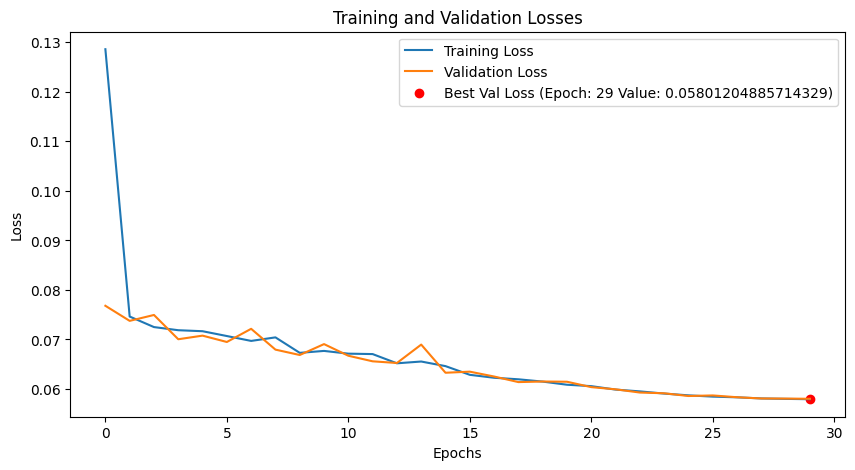

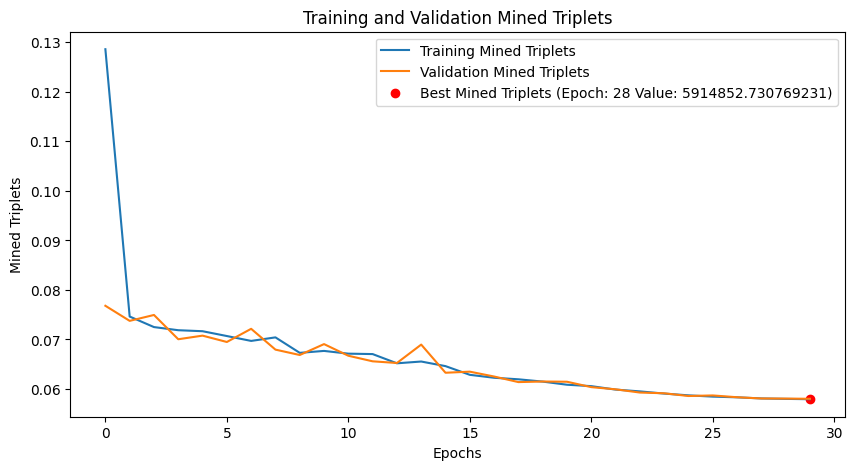

In [ ]:
best_val_loss = min(val_losses)
best_val_loss_epoch = val_losses.index(best_val_loss)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.scatter(best_val_loss_epoch, best_val_loss, color='red', label=f'Best Val Loss (Epoch: {best_val_loss_epoch} Value: {best_val_loss})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

best_mined_triplets = min(val_mined_triplets)
best_mined_triplets_epoch = val_mined_triplets.index(best_mined_triplets)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Mined Triplets')
plt.plot(val_losses, label='Validation Mined Triplets')
plt.scatter(best_val_loss_epoch, best_val_loss, color='red', label=f'Best Mined Triplets (Epoch: {best_mined_triplets_epoch} Value: {best_mined_triplets})')
plt.xlabel('Epochs')
plt.ylabel('Mined Triplets')
plt.legend()
plt.title('Training and Validation Mined Triplets')
plt.show()

Embedding Graphs

In [ ]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10, 10))
    for i in range(8):
        inds = np.where(targets == i)[0]
        plt.scatter(embeddings[inds, 0], embeddings[inds, 1], alpha=0.5, color=colors[i], label=classes[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(loc='best')
    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.title("t-SNE Embeddings")

def extract_embeddings(model, dataloader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in dataloader:
            inputs, target_labels = data
            inputs = inputs.to(device)
            emb = model.get_embedding(inputs)
            embeddings.append(emb.cpu().numpy())
            labels.append(target_labels.cpu().numpy())
    return np.concatenate(embeddings), np.concatenate(labels)

test_embeddings, test_embedding_labels = extract_embeddings(embedding_model, audio_test_loader)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7ed3d2621f30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so: cannot open shared object file: No such file or directory


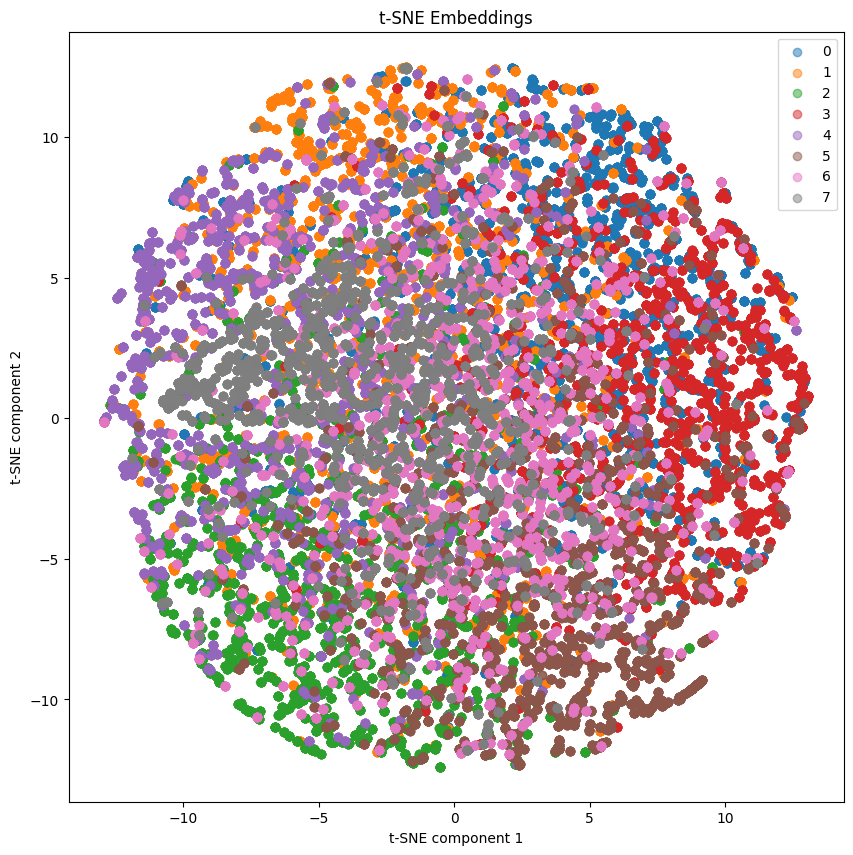

In [ ]:
def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, perplexity=50, learning_rate=10, n_iter=1000, random_state=42)
    return tsne.fit_transform(embeddings)

test_embeddings_tsne = apply_tsne(test_embeddings)
plot_embeddings(test_embeddings_tsne, test_embedding_labels)
plt.show()

# Unassign

In [ ]:
runtime.unassign()